In [179]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA, ARIMAResults, ARMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')

### Import data

In [148]:
url = "https://raw.githubusercontent.com/ccodwg/Covid19Canada/master/timeseries_prov/cases_timeseries_prov.csv"
df = pd.read_csv(url)
df["date_report"] = pd.to_datetime(df["date_report"], format="%d-%m-%Y")
df.head()

,province,date_report,cases,cumulative_cases
0,Alberta,2020-01-25,0,0
1,Alberta,2020-01-26,0,0
2,Alberta,2020-01-27,0,0
3,Alberta,2020-01-28,0,0
4,Alberta,2020-01-29,0,0


### Cleaning and transforming

In [166]:
# df.columns = [x.lower() for x in df.columns]
indexer = df[df["province"]=="BC"].index
bc_df = df.loc[indexer, "date_report":"cases"]
bc_df.set_index("date_report", inplace=True)
bc_df["t30_cases"] = bc_df.rolling(window=30).mean()["cases"]
bc_df.drop(bc_df.columns.difference(["t30_cases"]), 1, inplace=True) # drop all other cols
bc_df = bc_df.asfreq("d")
bc_df.dropna(inplace=True)
bc_df.index

DatetimeIndex(['2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03',
               ...
               '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
               '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29',
               '2021-03-30', '2021-03-31'],
              dtype='datetime64[ns]', name='date_report', length=403, freq='D')

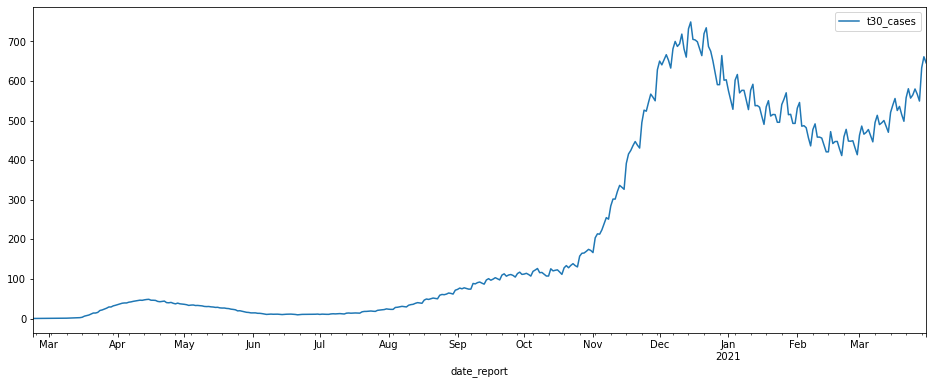

In [194]:
bc_df.plot(figsize=(16,6));
# bc_df["rollmean_7_cases"].plot()

### Making data stationary

Dicky-Fuller Test
Test Statistic     -1.969409
p-value             0.300145
#Lags Used         14.000000
# Obs. Used       387.000000
dtype: float64


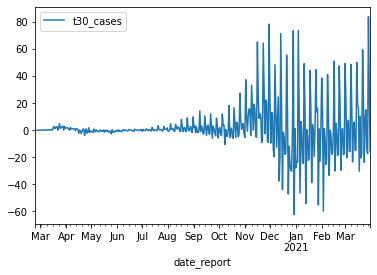

In [178]:
diff_bc_df = bc_df.diff().dropna()
diff_bc_df.plot()
adf_test(diff_bc_df)

In [151]:
# a p-value of greater than 0.05 means data is non-stationary
def adf_test(ts):
    print("Dicky-Fuller Test")
    dftest = adfuller(ts, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "# Obs. Used"])
    print(dfoutput)

adf_test(bc_df)

Dicky-Fuller Test
Test Statistic     -0.83534
p-value             0.80852
#Lags Used         15.00000
# Obs. Used       387.00000
dtype: float64


### Auto ARIMA

In [202]:
# start_p = 0 assumes there is no AR component
# start_q = 0 also to suggest no order for MA
# Define we are searching for 24 different models 6 * 4
# Seasonal is set to False since it is stationary
# Trace shows the 1st couple ARIMA models it tried to fit
step_fit = auto_arima(bc_df, start_p=0, start_q=0, 
                      max_p=5, max_q=3, 
                      seasonal=False, trace=True)

# Returns AIC and BIC which estimate the quality of the models
# Then summary provides the best performing model
step_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3462.877, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3464.638, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3464.104, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3464.111, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3455.190, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3408.572, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3411.479, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3406.216, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3404.534, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3404.932, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3396.498, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3362.472, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3363.323, Time=0.06 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3211.709, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  403
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -1596.854
Date:                Thu, 01 Apr 2021   AIC                           3211.709
Time:                        00:42:49   BIC                           3247.677
Sample:                             0   HQIC                          3225.950
                                - 403                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3362      1.659      1.408      0.159      -0.915       5.587
ar.L1         -0.1543      0.038     -4.026      0.000      -0.229      -0.079
ar.L2         -0.7812      0.043    -18.282      0.000      -0.865      -0.697
ar.L3         -0.0428      0.043     -0.992      0.321      -0.127       0.042
ar.L4         -0.0698      0.043     -1.605      0.108      -0.155       0.015
ar.L5         -0.3607      0.031    -11.477      0.000      -0.422      -0.299
ma.L1          0.2583      0.017     15.058      0.000       0.225       0.292
ma.L2          0.8886      0.022     40.427      0.000       0.846       0.932
sigma2       163.9782      5.991     27.369      0.000     152.235     175.721
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              1003.30
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):             163.88   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Train-test split based on 80:20

In [172]:
train_df = bc_df[:int(bc_df.shape[0]*0.8)]
test_df = bc_df[int(bc_df.shape[0]*0.8):]
test_df.head()

,t30_cases
date_report,
2021-01-10,527.833333
2021-01-11,577.000000
2021-01-12,591.866667
2021-01-13,537.633333
2021-01-14,538.166667


### ARIMA

In [188]:
model = ARIMA(train_df, order=(5,1,2))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              t30_cases   No. Observations:                  322
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -1222.053
Date:                Thu, 01 Apr 2021   AIC                           2460.105
Time:                        00:30:57   BIC                           2490.277
Sample:                    02-23-2020   HQIC                          2472.152
                         - 01-09-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0823      0.035     -2.332      0.020      -0.151      -0.013
ar.L2         -0.6813      0.037    -18.401      0.000      -0.754      -0.609
ar.L3          0.1249      0.041      3.055      0.002       0.045       0.205
ar.L4          0.0416      0.040      1.029      0.304      -0.038       0.121
ar.L5         -0.2815      0.030     -9.313      0.000      -0.341      -0.222
ma.L1          0.2325      0.025      9.341      0.000       0.184       0.281
ma.L2          0.8727      0.032     27.280      0.000       0.810       0.935
sigma2       116.7469      3.984     29.301      0.000     108.938     124.556
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2264.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             216.58   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date_report'>

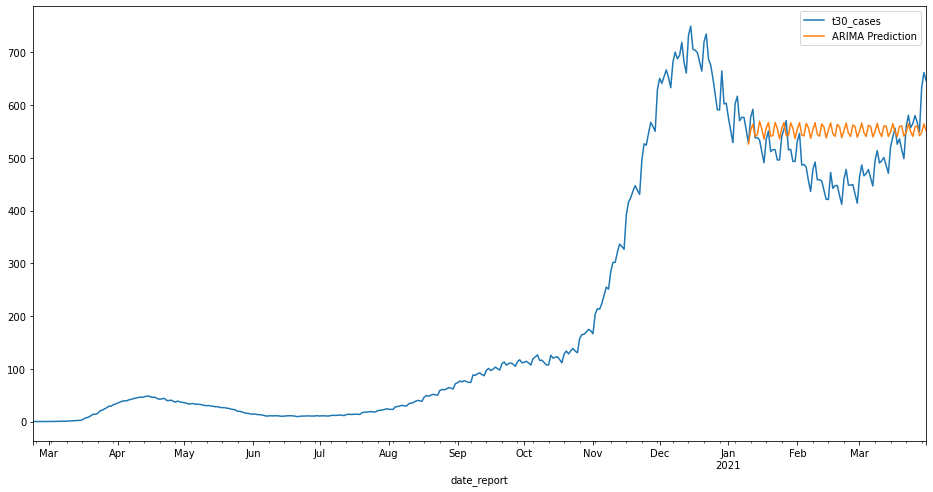

In [189]:
# Get predicted values
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end).rename('ARIMA Prediction')

# Plot Prediction
bc_df.plot(figsize=(16,8), legend=True)
prediction.plot(legend=True)

### SARIMAX

In [203]:
model_sarimax = SARIMAX(train_df, order=(5,1,2))
res_sarimax = model_sarimax.fit()
res_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              t30_cases   No. Observations:                  322
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -1222.053
Date:                Thu, 01 Apr 2021   AIC                           2460.105
Time:                        00:43:33   BIC                           2490.277
Sample:                    02-23-2020   HQIC                          2472.152
                         - 01-09-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0823      0.035     -2.332      0.020      -0.151      -0.013
ar.L2         -0.6813      0.037    -18.401      0.000      -0.754      -0.609
ar.L3          0.1249      0.041      3.055      0.002       0.045       0.205
ar.L4          0.0416      0.040      1.029      0.304      -0.038       0.121
ar.L5         -0.2815      0.030     -9.313      0.000      -0.341      -0.222
ma.L1          0.2325      0.025      9.341      0.000       0.184       0.281
ma.L2          0.8727      0.032     27.280      0.000       0.810       0.935
sigma2       116.7469      3.984     29.301      0.000     108.938     124.556
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2264.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             216.58   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

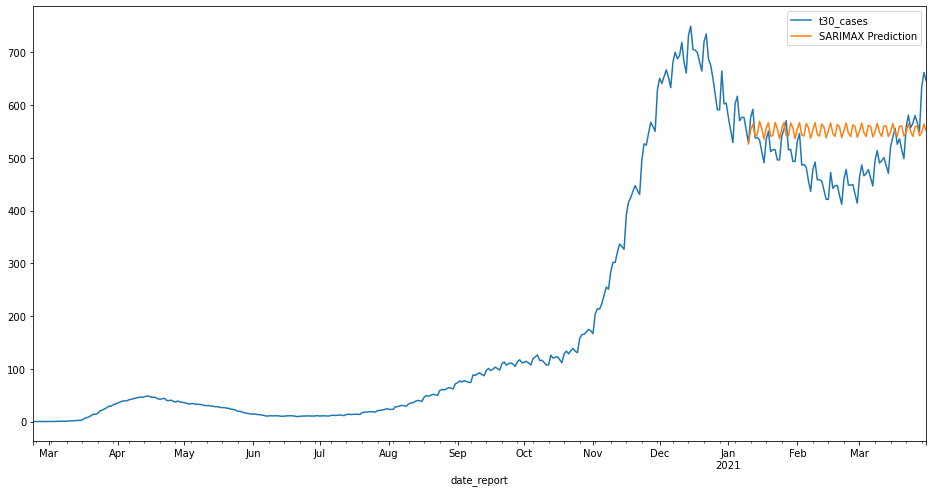

In [204]:
# Get predicted values
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction_sarimax = res_sarimax.predict(start, end).rename('SARIMAX Prediction')

# Plot Prediction
bc_df.plot(figsize=(16,8), legend=True);
prediction_sarimax.plot(legend=True);

In [186]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAE: ", mean_absolute_error(test_df, prediction_sarimax))
print("MSE: ", mean_squared_error(test_df, prediction_sarimax))
print("RMSE: ", np.sqrt(mean_squared_error(test_df, prediction_sarimax)))
print("MAPE: ", mean_absolute_percentage_error(test_df, prediction_sarimax)) # watch out for divide by zero error

MAE:  12.933552218630753
MSE:  342.26462613692036
RMSE:  18.500395296774617
MAPE:  11.502499317119426


### Predict BC Covid-19 cases 1 year into the future

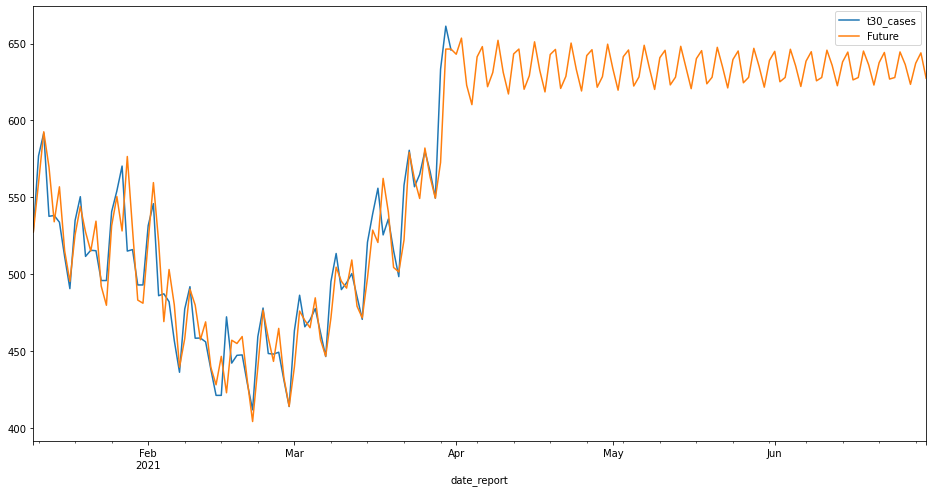

In [201]:
future = res_sarimax.predict(len(train_df), len(bc_df)+90).rename('Future')
test_df.plot(legend=True, figsize=(16,8));
future.plot(legend=True);